In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import requests
import datetime
import time
import json
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import concurrent.futures
import logging
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
logging.getLogger().setLevel(logging.INFO)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import sys
import numpy as np
import shap
from tempfile import mkdtemp
logging.getLogger().setLevel(logging.INFO)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
cachedir = mkdtemp()
from shap import summary_plot

In [ ]:
def training_and_testing_model(train_test_sample):                #### Training and Testing Model
    train_test_sample_numerical = train_test_sample[
        ["fraud", "num_of_client_bets_before_bet",  "profit_ratio", 
         "price_ratio", "total_client_roi_before_bet", "state", 
         "side", "betplace_matchstart_timedifference","handicap", "in_play",
         "Currency", "num_of_selection_bets_before", "back_liquidity", "lay_liquidity",
         "bet_create_matched_timedifference", "total_matched_ratio", "daily_profit", "daily_stakes"]]
    train_test_sample_numerical.info()
    y = train_test_sample_numerical['fraud']                   ##### TEST SPLIT
    X = train_test_sample_numerical.drop('fraud', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    xgb_model = XGBClassifier(random_state = 42, enable_categorical = True)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    print(classification_report(y_test, y_pred))
    train_score = xgb_model.score(X_train, y_train)
    test_score = xgb_model.score(X_test, y_test)
    print(f"Training score {train_score}")
    print(f"Test score {test_score}")
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

    importances = xgb_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by= 'importance', ascending = False)
    plt.figure(figsize = (10,6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Xgboost Feature Importance')
    plt.gca().invert_yaxis()
    bars = plt.barh(importance_df['feature'], importance_df['importance'])
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.4f}', 
                va='center', ha='left', color='black', fontsize=10)
    plt.show()
    return xgb_model, X_train, X_test, y_train, y_test




def grid_search(X_train, X_test, y_train, y_test):              #### GRID SEARCH 
    pipeline = Pipeline([
        ('classifier', XGBClassifier(random_state = 42, eval_metric = 'logloss'))
    ])
    param_grid = {
        'classifier__n_estimators' : [1300, 1400],
        'classifier__max_depth': [11, 12],
        'classifier__learning_rate': [0.08, 0.09],
        'classifier__subsample': [0.8,0.90]
    }
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv =5,
        scoring = 'accuracy',
        n_jobs = -1,
        verbose = 1
    )
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    print('Best cross-validation score:', grid_search.best_score_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(classification_report(y_test, y_pred))
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)
    print(f"Training score {train_score}")
    print(f"Test score {test_score}")
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    return best_model




def validation_test(best_model, validation_data):               #### VALIDATION TEST WITH NEW DATA
    validation_data_numerical = validation_data[
        ["fraud", "num_of_client_bets_before_bet",  "profit_ratio", 
         "price_ratio", "total_client_roi_before_bet", "state", 
         "side", "betplace_matchstart_timedifference","handicap", "in_play",
         "Currency", "num_of_selection_bets_before", "back_liquidity", "lay_liquidity",
         "bet_create_matched_timedifference", "total_matched_ratio", "daily_profit", "daily_stakes"]]
    y_recent = validation_data_numerical["fraud"]
    X_recent = validation_data_numerical.drop("fraud", axis =1)
    y_recent_pred = best_model.predict(X_recent)

    print("=== Evaluation on Recent (Validation) Data ===")
    print(classification_report(y_recent, y_recent_pred))
    cm_recent = confusion_matrix(y_recent, y_recent_pred)
    tn, fp, fn, tp = cm_recent.ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    cv_scores = cross_val_score(best_model, X_recent, y_recent, cv = 5)
    print(f"Mean CV score: {cv_scores.mean()}")
    return y_recent_pred




def new_daily_bets_test(best_model):                                    #### REAL TEST
    last_week_bets = pd.read_parquet('data/newdaybets', engine = 'pyarrow')
    customer_ids = last_week_bets[["customer_id", "price", "id", "settled_date", "creation_date", "matched_date", "market_start_time","last_modified", "virtual_size", "virtual_size_matched", "virtual_profit", "event_type_name", "currency_margin"]]
    last_week_bets = last_week_bets[
        ["num_of_client_bets_before_bet", "profit_ratio", 
        "price_ratio", "total_client_roi_before_bet", "state", 
        "side", "betplace_matchstart_timedifference","handicap", "in_play",
        "Currency", "num_of_selection_bets_before", "back_liquidity", "lay_liquidity",
        "bet_create_matched_timedifference", "total_matched_ratio", "daily_profit", "daily_stakes"]]
    predicted_labels = best_model.predict(last_week_bets)
    predicted_probs = best_model.predict_proba(last_week_bets)
    last_week_bets["predicted_labels"] = predicted_labels
    predicted_probs_df = pd.DataFrame(predicted_probs, 
                                    index=last_week_bets.index,
                                    columns=["prob_0", "prob_1"])
    last_week_bets = pd.concat([last_week_bets, predicted_probs_df], axis=1)
    result = last_week_bets.merge(customer_ids, left_index=True, right_index=True)
    result["expected_company_saved_cost"] = result["daily_profit"] * result["currency_margin"]
    result = result[["id", "customer_id", "prob_1", "daily_profit", "currency_margin", "expected_company_saved_cost","event_type_name", "creation_date", "matched_date", "market_start_time", "last_modified", "price", 
                    "side", "virtual_size", "virtual_size_matched", "virtual_profit", "total_client_roi_before_bet", 
                    "num_of_selection_bets_before", "num_of_client_bets_before_bet", "price_ratio",  "profit_ratio"]]
    result = result[result["prob_1"] >= 0.5]
    result["creation_date"] = pd.to_datetime(result["creation_date"], unit = "ms")
    result["matched_date"] = pd.to_datetime(result["matched_date"], unit = "ms")
    result["market_start_time"] = pd.to_datetime(result["market_start_time"], unit = "ms")
    result["last_modified"] = pd.to_datetime(result["last_modified"], unit = "ms")
    result = result.sort_values(by = ["daily_profit", "customer_id","prob_1"], ascending=False)
    result = result[result["daily_profit"] >= 500]
    result.to_csv("data/fraud_bets.csv", index=False)
    result
    return result




def shap_graph(xgb_model):                                             #### SHAP
    last_week_bets = pd.read_parquet('newdaybets', engine = 'pyarrow')
    customer_ids = last_week_bets[['customer_id', "id", "settled_date"]]
    last_week_bets = last_week_bets[
        ["num_of_client_bets_before_bet",  "profit_ratio", 
        "price_ratio", "total_client_roi_before_bet", "state", 
        "side", "betplace_matchstart_timedifference","handicap", "in_play",
        "Currency", "num_of_selection_bets_before", "back_liquidity", "lay_liquidity",
        "bet_create_matched_timedifference", "total_matched_ratio", "daily_profit", "daily_stakes"]]
    explainer = shap.TreeExplainer(xgb_model)
    feature_columns = last_week_bets.columns
    shap_values = explainer.shap_values(last_week_bets)
    shap,summary_plot(shap_values, last_week_bets)
    return

In [ ]:
train_test_sample = pd.read_parquet('data/train_test_sample', engine = 'pyarrow')
validation_data = pd.read_parquet('data/validation_data', engine = 'pyarrow')
train_test_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206229 entries, 0 to 206228
Data columns (total 58 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   id                                  206229 non-null  int64         
 1   customer_id                         206229 non-null  category      
 2   creation_date                       206229 non-null  int64         
 3   last_modified                       206229 non-null  int64         
 4   settled_date                        206229 non-null  int64         
 5   event_type_id                       206229 non-null  int64         
 6   event_type_name                     206229 non-null  object        
 7   event_name                          206229 non-null  category      
 8   market_name                         206229 non-null  object        
 9   market_id                           206229 non-null  object        
 10  market_s

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206229 entries, 0 to 206228
Data columns (total 18 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   fraud                               206229 non-null  int64  
 1   num_of_client_bets_before_bet       206229 non-null  int64  
 2   profit_ratio                        206225 non-null  float64
 3   price_ratio                         206229 non-null  float64
 4   total_client_roi_before_bet         206229 non-null  float64
 5   state                               206229 non-null  int64  
 6   side                                206229 non-null  int64  
 7   betplace_matchstart_timedifference  206229 non-null  int64  
 8   handicap                            206229 non-null  float64
 9   in_play                             206229 non-null  int64  
 10  Currency                            206229 non-null  float64
 11  num_of_selection_bets_befo

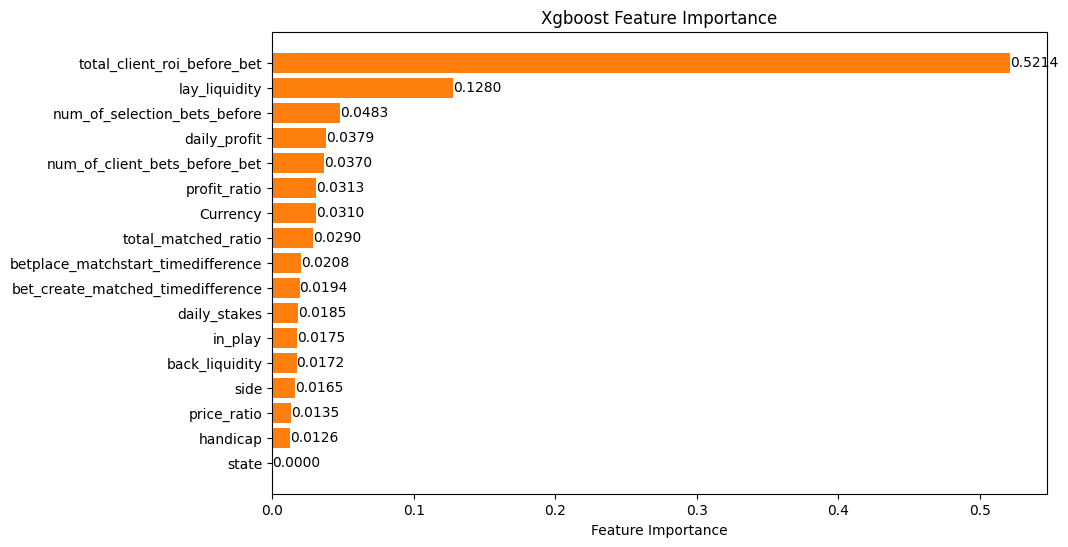

In [ ]:
xgb_model, X_train, X_test, y_train, y_test = training_and_testing_model(train_test_sample)

In [ ]:
best_model = grid_search(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'classifier__learning_rate': 0.09, 'classifier__max_depth': 12, 'classifier__n_estimators': 1400, 'classifier__subsample': 0.9}
Best cross-validation score: 0.9963208322832025
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40039
           1       0.95      0.94      0.95      1207

    accuracy                           1.00     41246
   macro avg       0.97      0.97      0.97     41246
weighted avg       1.00      1.00      1.00     41246

Training score 1.0
Test score 0.9967996896668768
True Negatives: 39976
False Positives: 63
False Negatives: 69
True Positives: 1138


In [ ]:
y_recent_pred = validation_test(best_model, validation_data)

=== Evaluation on Recent (Validation) Data ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    200000
           1       0.88      0.92      0.90       855

    accuracy                           1.00    200855
   macro avg       0.94      0.96      0.95    200855
weighted avg       1.00      1.00      1.00    200855

True Negatives: 199898
False Positives: 102
False Negatives: 72
True Positives: 783
Mean CV score: 0.9994971496850964
